<strong><font size="8">A3</font></strong>

In [90]:
import mne
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pathlib

import eelbrain
import eelbrain.datasets._alice
from scipy.stats import ttest_1samp #import 1 sample t-test
from scipy.stats import pearsonr #import pearson correlation library 

DATA_ROOT = eelbrain.datasets._alice.get_alice_path() #gets dataset from C:\User\<USERNAME>\Data\Alice

STIMULUS_DIR = DATA_ROOT / 'stimuli' #stimulus data
EEG_DIR = DATA_ROOT / 'eeg' #eeg data
LOW_FREQ = 0.5 #definitions to be used throughout
HIGH_FREQ = 20

print(f"{mne.__version__=}")
print(DATA_ROOT)

mne.__version__='1.9.0'
C:\Users\snowy\Data\Alice


<strong><font size="6">1</font></strong>

In [91]:
#----------------------# PREPROCESSING #----------------------#

SUBJECT = 'S01' #uses the first subject for part 1

raw = mne.io.read_raw(EEG_DIR / SUBJECT / f'{SUBJECT}_alice-raw.fif', preload = True) #reads in the subjects .fif file 
raw.filter(LOW_FREQ, HIGH_FREQ, n_jobs = 1) #filters the raw based on tutorial recommendation, defaults to single job running only
raw.interpolate_bads() #interpolate bad channels

events = eelbrain.load.mne.events(raw) #extracts events from the raw data
# events

#----------------------# GENERATE ENVELOPE #----------------------#

envelopes = []
for stimulus_id in events['event']: 
    wav = eelbrain.load.wav(STIMULUS_DIR / f'{stimulus_id}.wav') #NOTE: there are 12 events (.wav files) in the stimulus folder, so always 12 events for each subject
    envelope = wav.envelope() #computes acoustic envelope
    envelope = eelbrain.filter_data(envelope, LOW_FREQ, HIGH_FREQ, pad='reflect')
    envelope = eelbrain.resample(envelope, 100)
    envelopes.append(envelope)

events['envelope'] = envelopes #adds the envelopes to the events table

#----------------------# EEG PROCESSING #----------------------#

events['onsets']  = [envelope.diff('time').clip(0) for envelope in envelopes] #identifies onsets within the envelope, by taking positive sudden changes and creating a 2nd predictor
events['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']]) #extracts stimulus duration
events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto') #extracts EEG data @ time of envelope

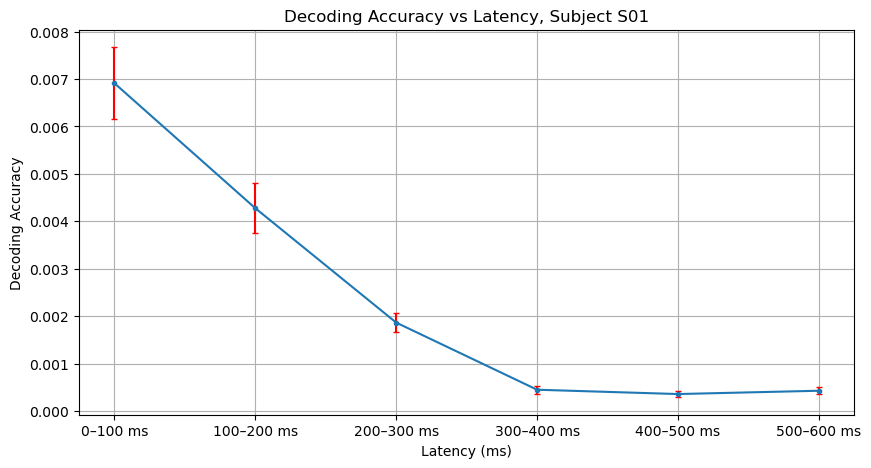

In [92]:
#----------------------# TRF #----------------------#

latencies = [(0,100), (100,200), (200, 300), (300,400), (400,500), (500,600)] #defines the 6 latency windows btwn 0 and 600ms

accuracy = [] #array for accuracy in each latency window
error = [] #arry for error in each latency window
pVals = [] #array for p values for t-test

for i in range(len(latencies)):
    tmin, tmax = latencies[i] #defines tmin and tmax to be used in eelbrain.boosting() in ms

    trf = eelbrain.boosting('eeg', ['envelope', 'onsets'], tmin/1000, tmax/1000, delta=0.05, data=events, partitions=4) #considers both envelope data and the onesets data, converts time into s from ms, and takes 4 partitions (default to 10 which breaks eelbrain)

    predPower = trf.proportion_explained.x #predictive power across the sensors, basically the reconstruction accuracy on a held-out dataset. .x pulls out the data only
    # print(type(predPower))
    
    meanAcc = np.mean(predPower) #mean accuracy across all points in the latency window
    errAcc = np.std(predPower)/np.sqrt(len(predPower)) #error across all points in the latency window
    ttest = ttest_1samp(predPower, 0) #single-sample t-test from the accuracy of each latency window. null-hypothesis is 0, since any value above 0 for "proportion_explained" means some amount of variance/predicatbility

    accuracy.append(meanAcc)
    error.append(errAcc)
    pVals.append(ttest[1]) #appends just the p value to the array (don't care about t-statistic outputted)

#----------------------# PLOTTING #----------------------#
x_labels = [f"{tmin}–{tmax} ms" for tmin, tmax in latencies] #labels indicating range (for clarity instead of 0ms, 100ms, etc)

plt.figure(figsize=(10,5)) #strched for better readability
plt.errorbar(x = x_labels, y=accuracy, yerr=error, fmt='.-', ecolor='r', capsize=2, label="Decoding Accuracy") #plots decoding, adds red error bars w/ endcaps for readability
plt.xlabel('Latency (ms)')
plt.ylabel('Decoding Accuracy')
plt.title(f'Decoding Accuracy vs Latency, Subject {SUBJECT}')
plt.grid() #shows gridlines for readability
plt.show()

In [93]:
print("Latency ranges with above-chance decoding:")
for i, p in enumerate(pVals):
    if p < 0.05:
        print(f"{latencies[i][0]}–{latencies[i][1]} ms (p = {p:.10f})") #outputs the latency ranges and their associated p-values, if they are statistically significant

Latency ranges with above-chance decoding:
0–100 ms (p = 0.0000000000)
100–200 ms (p = 0.0000000000)
200–300 ms (p = 0.0000000000)
300–400 ms (p = 0.0000010560)
400–500 ms (p = 0.0000013982)
500–600 ms (p = 0.0000010193)


As we can see, it seems that at EVERY time step (aka latency window) there is a statistically significant amount of information encoded by the cortical EEG response. This was determined by using a 1-step t-test, to determine the p-values of each point. While a p-value of 0.05 was chosen as the threshold, each of the points was actually much much smaller, meaning that even if we were to use a significantly lower value (aka much higher confidence interval) we would still see that each of the 6 latency windows would give relevant information. 

While the current output shows subject S01, it should be noted that the same results were found for both subject S18 and S20. 

<strong><font size="6">2</font></strong>

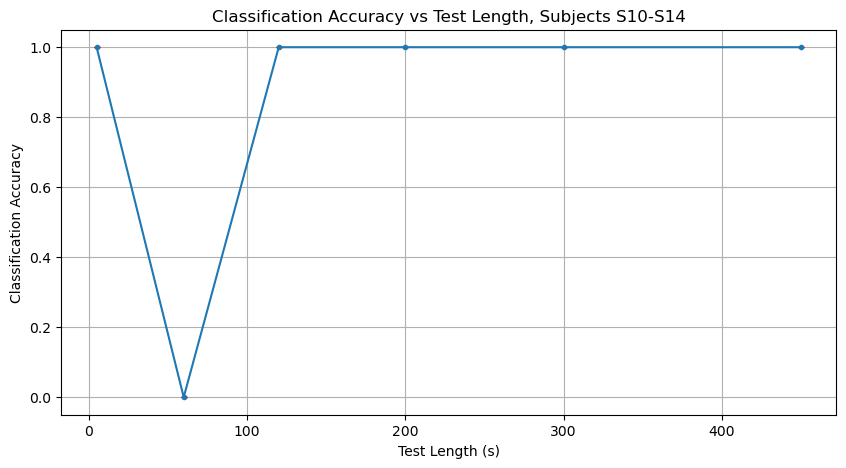

In [134]:
SUBJECTS = [f'S{i:02d}' for i in range(10, 15)]  #S10 to S19, since all exist (not all subjects from 01-48 exist, so just work w/ subset)
# SUBJECTS = ['S10','S11']
# print(SUBJECTS)

lenTests = [5, 60, 120, 200, 300, 450] #different test lengths, randomly selected
# lenTests = [5, 60]

results = {length: [] for length in lenTests} #dictionary for storing each subjects accuracy by the length of the trial

for subject in SUBJECTS:
    
    #--- LOADING/PREPROCESSING ---#
    raw = mne.io.read_raw(EEG_DIR / SUBJECT / f'{SUBJECT}_alice-raw.fif', preload = True) 
    raw.filter(LOW_FREQ, HIGH_FREQ, n_jobs = 1) 
    raw.interpolate_bads() 

    events = eelbrain.load.mne.events(raw) 
    # print(events)


    #--- GENERATING ENVELOPE ---#
    envelopes = []
    for stimulus_id in events['event']: 
        wav = eelbrain.load.wav(STIMULUS_DIR / f'{stimulus_id}.wav')
        envelope = wav.envelope()
        envelope = eelbrain.filter_data(envelope, LOW_FREQ, HIGH_FREQ, pad='reflect')
        envelope = eelbrain.resample(envelope, 100)
        envelopes.append(envelope)

    events['envelope'] = envelopes 

    #--- EEG PROCESSING ---#
    # events['onsets']  = [envelope.diff('time').clip(0) for envelope in envelopes] 
    events['duration'] = eelbrain.Var([envelope.time.tstop for envelope in events['envelope']]) #extracts stimulus duration
    events['eeg'] = eelbrain.load.mne.variable_length_epochs(events, 0, tstop='duration', decim=5, connectivity='auto') #extracts EEG data @ time of envelope

    #--- TRF N-2 TRIALS ---#
    numTrials = len(events) 
    trainEvents = events[:numTrials-2] 
    
    trf = eelbrain.boosting('eeg', 'envelope', -0.100, 0.500, delta=0.05, data=trainEvents, partitions=4) #same as above, but using -100ms to 500ms (from tutorial). also removed onsets and only look at envelope

    #--- CLASSIFYING TRIALS ---#
    trialN = events[numTrials-1] #trial N
    trialN_1 = events[numTrials-2] #trial N-1

    # print(f"envN total length: {np.shape(trialN['eeg'])}") #shows that each element has max size of 6378 samples so sizes will have to be adjusted. 5 -> 500 in shape so need to divide by 100
    # print(f"envN_1 length: {np.shape(trialN_1['eeg'])}")
    # tempRes = []
    
    for length in lenTests:

        eegN = trialN['eeg'].sub(time=(0, length/100)) #subset of EEG data from 0 to the length given, in seconds
        eegN_1 = trialN_1['eeg'].sub(time=(0, length/100)) #subset of EEG data from 0 to the length given, in seconds

        predEnv = eelbrain.convolve(trf.h, eegN) #predicted envelope for trial N, using trf learned "weights" as kernel and eegN as the infomation to convolve over

        envN = trialN['envelope'].sub(time=(0, length/100)) #real envelope for trial N
        envN_1 = trialN_1['envelope'].sub(time=(0, length/100)) #real envelope for trial N-1

        #--- PEARSON CORRELATION ---#
        rN = pearsonr(predEnv.x, envN.x)[0] #r-value correlation between the real and estimated envelopes
        # print(type(predEnv), type(envN))
        # print(np.shape(predEnv), np.shape(envN), np.shape(envN_1))
        rN_1 = pearsonr(predEnv.x, envN_1.x)[0]

        results[length].append(1 if rN > rN_1 else 0) #appends whether or not we have a correcltly classified trial "N" at the array in the dict representing the length of the trial
        # print(f'Subject {subject}, Time {length}')
        # print(f'r(N) {rN}, r(N-1) {rN_1}')
        # tempRes.append(1 if rN > rN_1 else 0)
    # print(f'Results: {tempRes}')
    
# print(results)

#--- MEAN/ERROR ---#
means = []
stdevs = []

for length in lenTests:
    accuracies = results[length]
    means.append(np.mean(accuracies))
    stdevs.append(np.std(accuracies)/np.sqrt(len(accuracies)))

#--- PLOTTING ---#
plt.figure(figsize=(10,5))
plt.errorbar(x=lenTests, y=means, yerr=stdevs, ecolor='r', fmt='.-', capsize=2, label='Accuracy')
plt.xlabel('Test Length (s)')
plt.ylabel('Classification Accuracy')
plt.title(f'Classification Accuracy vs Test Length, Subjects {SUBJECTS[0]}-{SUBJECTS[-1]}')
plt.grid() #shows gridlines for readability
plt.show()


I would have expected for the classification accuracy to react somewhat linearly with test length, this does not seem to be the case. As far as I was able to display, it seems that every point has perfect accuracy across subjects (note that this was also tested across subject S10-S19, but was reduced for time efficiency), except for at the 60s point at which the accuracy  is a perfect 0. As we can see, since the error bars don't appear at all, there is also NO variance.

I believe that this result may come from the fact that the events are the EXACT same for each subject (I tried printing it out and saw that they were all the same). This would lead to identical TRFs, and since the TRF is used to predeict the envelope, it would lead each subject to have an identical r-value when using pearson correlation. I am unsure as to how I would be able to solve the problem, as I do not believe that this should be the output.